In [23]:
from abc import ABC, abstractmethod
from pytrends.request import TrendReq
import yfinance as yf
import pandas as pd
import datetime as dt
from datetime import timedelta, date
from datetime import datetime

In [24]:
class extract(ABC):
    def __init__(self, start:str, end:str) -> None:
        self.start = start
        self.end = end
    def connect_API(self) -> None: pass
    @abstractmethod
    def collect_data(self): pass


class gtrend(extract):
    def __init__(self, keyword:str, start:str, end:str) -> None:
        self.keyword = keyword
        super().__init__(start, end)
        self.connect_API()
        
    def connect_API(self):
        self.pytrend = TrendReq()

    def collect_data(self):
        self.pytrend.build_payload(kw_list=['{}'.format(self.keyword)])
        data = self.pytrend.interest_over_time().reset_index()
        df = data[['date', '{}'.format(self.keyword)]]
        df_trend = df.loc[df.index.repeat(7)]
        df_trend['date'] = pd.to_datetime(df_trend['date'])
        min_date = df_trend['date'].min()
        max_date = df_trend['date'].max()+timedelta(days=6)
        df_trend['GT_date'] = pd.date_range(start=min_date, end=max_date).tolist()
        sd = datetime.strptime(self.start, "%Y-%m-%d").date()
        ed = datetime.strptime(self.end, "%Y-%m-%d").date()
        df_trend = df_trend[(df_trend['GT_date'].dt.date>=sd)&(df_trend['GT_date'].dt.date<=ed)]
        data_trend = df_trend[['GT_date', '{}'.format(keyword)]]
        return data_trend

class yahoo(extract):
    def __init__(self, keyword:str, start:str, end:str) -> None:
        self.ticker = ticker
        super().__init__(start, end)

    def collect_data(self):
        data = yf.download(self.ticker, start=self.start, end=self.end)
        return data

In [25]:
start = '2020-01-01'
end = '2021-01-01'
keyword = 'Wayfair'
ticker = 'W'

In [26]:
gt = gtrend(keyword, start, end)
yh = yahoo(ticker, start, end)

In [27]:
data_gt = gt.collect_data()
data_yh = yh.collect_data()

[*********************100%***********************]  1 of 1 completed


In [28]:
data_gt.head()

,GT_date,Wayfair
161,2020-01-01,30
161,2020-01-02,30
161,2020-01-03,30
161,2020-01-04,30
162,2020-01-05,26


In [163]:
data_yh.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,91.629997,94.800003,91.269997,93.139999,93.139999,1882500
2020-01-03,91.800003,94.129997,91.050003,94.040001,94.040001,1003600
2020-01-06,93.019997,94.830002,92.300003,94.669998,94.669998,1929500
2020-01-07,94.910004,96.580002,92.500000,95.699997,95.699997,1877400
2020-01-08,95.139999,97.362999,94.489998,95.169998,95.169998,2251200


## Model Fit

In [164]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

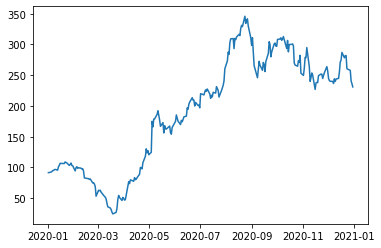

In [165]:
plt.plot(data_yh.Open)

In [166]:
data_yh.shape

(253, 6)

In [267]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
#     ds = ds.shuffle(shuffle_buffer)
    [print(x.numpy()) for x in ds.take(3)]
    print('finish shuffle')
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    [print(x) for x in ds.take(3)]
    return ds.batch(batch_size).prefetch(1)

In [268]:
series = np.array(data_yh.Open)

split_time = 200
x_train = series[:split_time]
x_valid = series[split_time:]

In [279]:
[print(x) for x in train_set.take(3)]

(<tf.Tensor: shape=(197, 3, 1), dtype=float64, numpy=
array([[[ 91.62999725],
        [ 91.80000305],
        [ 93.01999664]],

       [[ 91.80000305],
        [ 93.01999664],
        [ 94.91000366]],

       [[ 93.01999664],
        [ 94.91000366],
        [ 95.13999939]],

       [[ 94.91000366],
        [ 95.13999939],
        [ 96.26999664]],

       [[ 95.13999939],
        [ 96.26999664],
        [ 96.91000366]],

       [[ 96.26999664],
        [ 96.91000366],
        [ 95.72000122]],

       [[ 96.91000366],
        [ 95.72000122],
        [101.01000214]],

       [[ 95.72000122],
        [101.01000214],
        [103.5       ]],

       [[101.01000214],
        [103.5       ],
        [106.77999878]],

       [[103.5       ],
        [106.77999878],
        [106.61000061]],

       [[106.77999878],
        [106.61000061],
        [106.48999786]],

       [[106.61000061],
        [106.48999786],
        [109.05999756]],

       [[106.48999786],
        [109.05999756],
        [1

[None]

In [269]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
shuffle_buffer_size = 1000
window_size = 3
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(x_train.shape)

[[91.62999725]
 [91.80000305]
 [93.01999664]
 [94.91000366]]
[[91.80000305]
 [93.01999664]
 [94.91000366]
 [95.13999939]]
[[93.01999664]
 [94.91000366]
 [95.13999939]
 [96.26999664]]
finish shuffle
(<tf.Tensor: shape=(3, 1), dtype=float64, numpy=
array([[91.62999725],
       [91.80000305],
       [93.01999664]])>, <tf.Tensor: shape=(3, 1), dtype=float64, numpy=
array([[91.80000305],
       [93.01999664],
       [94.91000366]])>)
(<tf.Tensor: shape=(3, 1), dtype=float64, numpy=
array([[91.80000305],
       [93.01999664],
       [94.91000366]])>, <tf.Tensor: shape=(3, 1), dtype=float64, numpy=
array([[93.01999664],
       [94.91000366],
       [95.13999939]])>)
(<tf.Tensor: shape=(3, 1), dtype=float64, numpy=
array([[93.01999664],
       [94.91000366],
       [95.13999939]])>, <tf.Tensor: shape=(3, 1), dtype=float64, numpy=
array([[94.91000366],
       [95.13999939],
       [96.26999664]])>)
(200,)


In [170]:
train_set

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>

In [299]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=60, kernel_size=5,
    strides=1, padding="causal",
    activation="relu",
    input_shape=[None, 1]),
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 60)          360       
_________________________________________________________________
lstm (LSTM)                  (None, None, 60)          29040     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 60)          29040     
_________________________________________________________________
dense (Dense)                (None, None, 30)          1830      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0

In [264]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1, activation="linear")
])

In [300]:
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mae"])
history = model.fit(train_set,epochs=500)

/Users/rantao/Code/venvs/jupyter/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/500
1/1 [==============================] - 3s 3s/step - loss: 164.6173 - mae: 165.1173
Epoch 2/500
1/1 [==============================] - 0s 20ms/step - loss: 158.0860 - mae: 158.5858
Epoch 3/500
1/1 [==============================] - 0s 24ms/step - loss: 145.2626 - mae: 145.7619
Epoch 4/500
1/1 [==============================] - 0s 29ms/step - loss: 132.7724 - mae: 133.2722
Epoch 5/500
1/1 [==============================] - 0s 23ms/step - loss: 119.6126 - mae: 120.1100
Epoch 6/500
1/1 [==============================] - 0s 24ms/step - loss: 105.9010 - mae: 106.3997
Epoch 7/500
1/1 [==============================] - 0s 24ms/step - loss: 94.4980 - mae: 94.9970
Epoch 8/500
1/1 [==============================] - 0s 24ms/step - loss: 86.5120 - mae: 87.0116
Epoch 9/500
1/1 [==============================] - 0s 25ms/step - loss: 80.3742 - mae: 80.8732
Epoch 10/500
1/1 [==============================] - 0s 30ms/step - loss: 75.8906 - mae: 76.3906
Epoch 11/500
1/1 [=====================

In [298]:
print(model.layers[0].get_weights())

[array([[0.2980467]], dtype=float32), array([0.], dtype=float32)]


In [301]:
loss=history.history['loss']
epochs=range(len(loss)) # Get number of epochs

<Figure size 432x288 with 0 Axes>

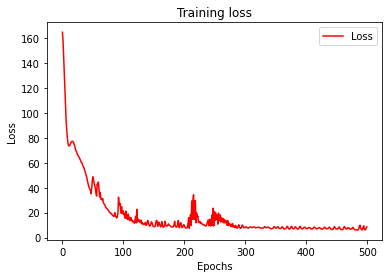

<Figure size 432x288 with 0 Axes>

In [302]:
plt.plot(epochs, loss, "r")
plt.title("Training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])
plt.figure()

In [303]:
zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)

<Figure size 432x288 with 0 Axes>

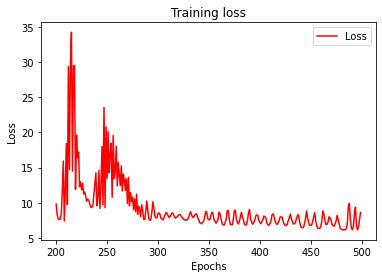

<Figure size 432x288 with 0 Axes>

In [304]:
plt.plot(zoomed_epochs, zoomed_loss, "r")
plt.title("Training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])
plt.figure()

In [305]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [306]:
def model_forecast(model, series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    print(forecast)
    return forecast

In [307]:
rnn_forecast= model_forecast(model, x_valid, window_size=3)

[[[302.17258]
  [307.94208]
  [307.49612]]

 [[302.35626]
  [308.36005]
  [305.3993 ]]

 [[302.86923]
  [306.944  ]
  [283.55194]]

 [[300.55356]
  [286.6287 ]
  [275.93698]]

 [[278.3508 ]
  [279.9064 ]
  [276.959  ]]

 [[275.379  ]
  [277.6303 ]
  [283.30255]]

 [[273.7522 ]
  [281.79523]
  [281.37628]]

 [[281.33276]
  [283.77634]
  [290.52808]]

 [[279.2031 ]
  [288.74243]
  [265.65448]]

 [[288.62418]
  [271.29422]
  [259.00958]]

 [[263.52933]
  [263.3258 ]
  [271.5845 ]]

 [[260.18005]
  [268.67874]
  [285.76434]]

 [[270.7274 ]
  [282.55774]
  [285.86514]]

 [[285.875  ]
  [289.9295 ]
  [300.10187]]

 [[285.45737]
  [297.31967]
  [274.0393 ]]

 [[298.44916]
  [281.21246]
  [251.18405]]

 [[273.15112]
  [257.80862]
  [254.66571]]

 [[250.98827]
  [255.74272]
  [264.56348]]

 [[256.83456]
  [262.9465 ]
  [262.7223 ]]

 [[263.8705 ]
  [263.95117]
  [240.90393]]

 [[260.85416]
  [243.60704]
  [244.53816]]

 [[237.76941]
  [244.06458]
  [249.38846]]

 [[248.52292]
  [249.58415]
  [2

In [308]:
x_valid

array([300.        , 300.25      , 300.95001221, 297.80999756,
       270.        , 266.54998779, 264.68499756, 273.51998901,
       271.        , 282.39001465, 253.32000732, 249.72000122,
       261.26000977, 279.        , 278.48999023, 295.        ,
       264.        , 240.11999512, 246.17999268, 253.69000244,
       250.44000244, 226.94999695, 237.61000061, 238.3500061 ,
       237.99000549, 249.28999329, 251.96000671, 251.75999451,
       244.74000549, 254.        , 264.        , 257.        ,
       245.        , 241.27999878, 240.19999695, 239.99000549,
       236.6000061 , 244.22000122, 239.91999817, 243.8500061 ,
       244.88999939, 255.3999939 , 271.64001465, 274.58999634,
       287.10998535, 278.29000854, 281.80999756, 282.01000977,
       260.55999756, 257.8999939 , 240.6499939 , 236.19999695,
       231.        ])

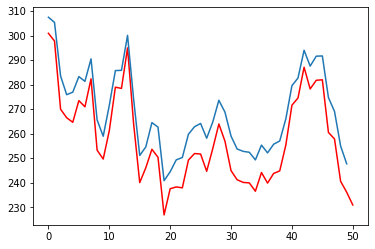

In [309]:
plt.plot(x_valid[2:], color='r')
plt.plot(rnn_forecast[:, -1, 0])

In [8]:
from abc import ABC, abstractmethod

class animals(ABC):
    def __init__(self, name:str) -> None:
        self.name = name
        
    def nature(self):
        print('I am an animal with name of {}'.format(self.name))
    
    @abstractmethod
    def move(self):
        pass

class dog(animals):
    def __init__(self, name:str) -> None:
        super().__init__(name)
        
    def nature(self):
        super().nature()
        
    def move(self):
        print('I can run')

In [7]:
d = dog('Nio')
d.nature()
d.move()

I am an animal with name of Nio
I can run


In [10]:
print(issubclass(dog, animals))

True


In [12]:
print(isinstance(dog('Nio'), animals))

True
